In [1]:
import scanpy as sc
import squidpy as sq

from util import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [ ]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

In [2]:
test = sc.read_h5ad('F://Rep11_MOB_ST.h5ad')
position_list = list(test.obs.index.str.split('x'))
arr = np.array(position_list, dtype=np.float32).reshape(len(position_list), 2)
test.obs['fig_x'] = arr[:,0] * 1000
test.obs['fig_y'] = arr[:,1] * 1000

F:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


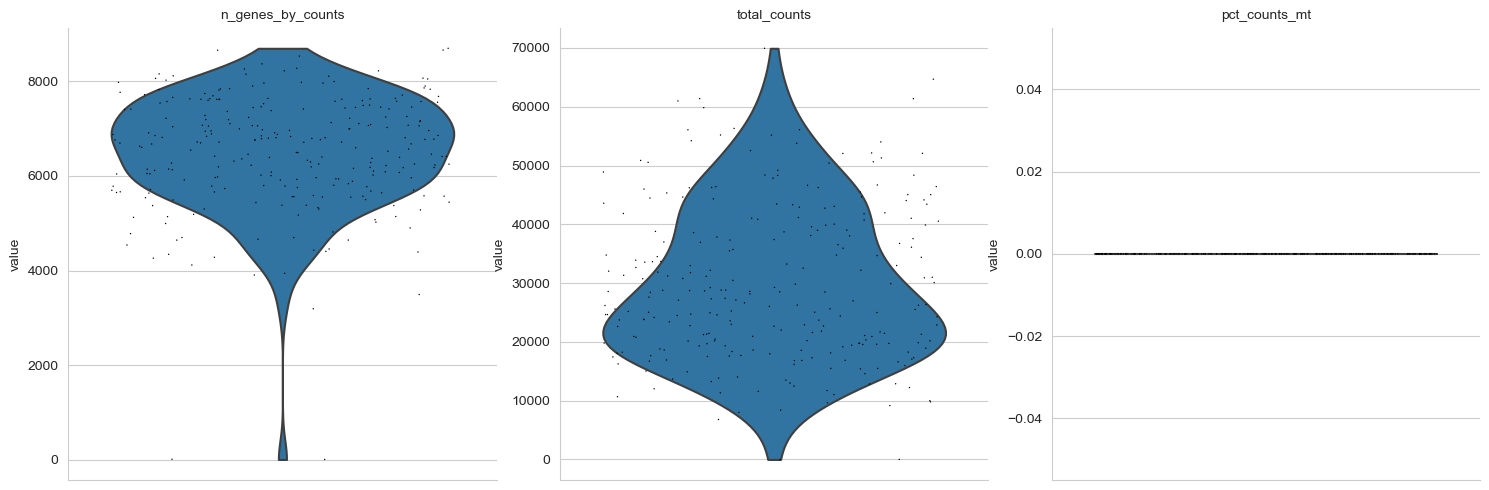

In [3]:
h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata = test
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [4]:
sc.pp.filter_genes(adata, min_cells=5)

In [ ]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

In [5]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 262 × 16218
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'fig_x', 'fig_y', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [6]:
gene_list = adata.var[adata.var['highly_variable']==True].index
len(gene_list)

3269

In [313]:
paper = ['Rab3b','Necab2','Tspan7','Cdr1','Slc17a7','4933405L10Rik','Taf7l','Gna14','Olfr635','Pmepa1','Pcp4','Apc','Rbfox3','Penk','Frzb','Fabp7','Slc6a11','Apod','S100a5','Arhgap33','Cplx1','Trnp1','Marcks','Atp1b1','Vtn','Trak2','Igf1','Gabra1','Igfbp2','Lpar1','Omp','Kif5b','Sorbs1','Cck','Nr2f2','Scd1','Cpe','Aqp4','Doc2g','Slc1a2','Nrgn','Cdhr1','Mcf2l','Kctd12','Unc13c','Foxd3','Prokr2','Gng13','Kcnh3','Camk2b','Baiap2','Ccnd1','Gpsm1','Pbx1','Sepp1','Apoe','Tubb2b','Ncdn','Glul','Sash1','Ptgds','Sparcl1','Mbp','Nrsn1','Igfbp5','Ptn','Sfrp5']

In [ ]:
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
gene_list

In [7]:
len(gene_list)

3269

In [10]:
gmm_dict = fit_gmms(adata, gene_list, n_comp=10, thread=4)

100%|██████████| 3269/3269 [00:00<00:00, 50292.63it/s]


In [ ]:
arr = build_distance_array(gmm_dict)

Processing:  20%|█▉        | 647/3269 [37:53<2:30:40,  3.45s/it]

In [16]:
gmm_dict[2]

3269

In [ ]:
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              color=list(['Vtn']))

In [576]:
def build_distance_array(gmm_dict: dict):
    # build graph
    gene_list = list(gmm_dict.keys())
    gene_counts = len(gene_list)
    distance_matrix = np.zeros((gene_counts, gene_counts), dtype=np.float64)
    # calculate the weight and add edges
    for i in range(gene_counts):
        for j in range(gene_counts):
            if i != j:
                distance = distribution_distance(gmm_dict[gene_list[i]], gmm_dict[gene_list[j]])
                distance_matrix[i][j] = distance
    return distance_matrix

arr = build_distance_array(gmm_dict)

In [419]:
g=build_graph(gmm_dict, distance_threshold=5)

In [556]:
distance_matrix = arr
min_distance = np.min(distance_matrix)
max_distance = np.max(distance_matrix)
normalized_distance_matrix = (distance_matrix - min_distance) / (max_distance - min_distance)

# 高斯核函数
similarity_matrix = np.exp(-normalized_distance_matrix**2 / (2 * 0.5**2))
# 构造拉普拉斯矩阵
D = np.diag(np.sum(similarity_matrix, axis=1))
L = D - similarity_matrix

# 进行特征值分解
eigenvalues, eigenvectors = np.linalg.eig(L)
idx = np.argsort(eigenvalues)[:3]
X = eigenvectors[:, idx]

# 对特征向量进行聚类
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors')
spectral.fit(X)

# 输出聚类结果
print(spectral.labels_)

[1 0 2 1 0 0 4 0 0 4 2 2 1 0 2 1 2 3 0 4 4 2 4 1 3 3 0 1 3 2 2 0 1 0 4 3 2
 3 3 2 1 0 1 1 4 1 4 2 2 0 4 4 0 4 2 3 2 3 0 2 0 3 3 3 2 3]


In [ ]:
from sklearn.cluster import SpectralClustering

k = 5  # 聚类数
clustering_model = SpectralClustering(n_clusters=k, affinity='precomputed', n_init=10)
clustering_model.fit(test)

# 打印聚类结果
print("Cluster labels:", clustering_model.labels_)

In [ ]:
len(list(clustering_model.labels_))

In [619]:
from sklearn.manifold import MDS
distance_matrix=arr
# distance_matrix为距离矩阵
mds = MDS(n_components=10, dissimilarity='precomputed')
embedding = mds.fit_transform(distance_matrix)

from sklearn.cluster import KMeans
# embedding为映射矩阵，n_clusters为聚类数目
kmeans = KMeans(n_clusters=6, random_state=0).fit(embedding)
# 获取聚类标签
labels = kmeans.labels_
labels

array([2, 5, 2, 1, 5, 5, 1, 5, 5, 5, 1, 2, 4, 5, 4, 1, 4, 2, 5, 4, 5, 1,
       1, 2, 1, 2, 5, 4, 4, 2, 2, 4, 1, 5, 1, 2, 4, 2, 2, 4, 1, 5, 2, 4,
       4, 4, 4, 4, 4, 5, 4, 1, 5, 4, 4, 2, 1, 2, 5, 3, 0, 0, 0, 2, 4, 1])

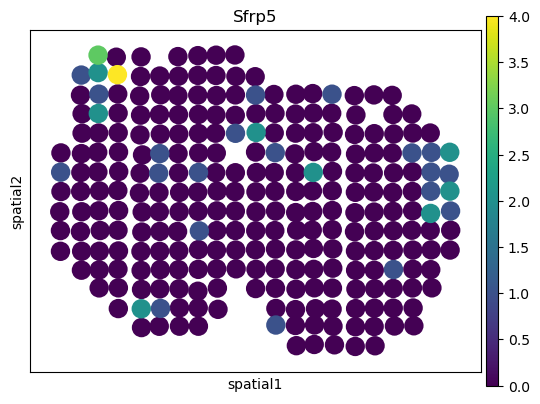

In [627]:
df = pd.DataFrame({'gene':list(gmm_dict.keys()), 'labels':list(kmeans.labels_)})
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              color=list(df[df['labels']==3]['gene']))

In [567]:
def build_distance_array(gmm_dict: dict):
    # build graph
    gene_list = list(gmm_dict.keys())
    gene_counts = len(gene_list)
    distance_matrix = np.zeros((gene_counts, gene_counts), dtype=np.float64)
    # calculate the weight and add edges
    for i in range(gene_counts):
        for j in range(gene_counts):
            if i != j:
                distance = distribution_distance(gmm_dict[gene_list[i]], gmm_dict[gene_list[j]])
                distance_matrix[i][j] = distance
    return distance_matrix
a={}
for i in list(gmm_dict.keys()):
    a[i] = gmm_dict[i]
aa = build_distance_array(a)
distance_matrix = aa
min_distance = np.min(distance_matrix)
max_distance = np.max(distance_matrix)
normalized_distance_matrix = (distance_matrix - min_distance) / (max_distance - min_distance)
similarity_matrix = np.exp(-normalized_distance_matrix**2 / (2 * 0.5**2))
similarity_matrix

array([[1.        , 0.19473819, 0.28049892, 0.33578286, 0.69600858],
       [0.19473819, 1.        , 0.2632477 , 0.32892342, 0.13533528],
       [0.28049892, 0.2632477 , 1.        , 0.5243196 , 0.17954595],
       [0.33578286, 0.32892342, 0.5243196 , 1.        , 0.26497051],
       [0.69600858, 0.13533528, 0.17954595, 0.26497051, 1.        ]])

In [ ]:
import networkx as nx
adj_matrix = nx.to_numpy_matrix(g)

In [ ]:
degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
laplacian_matrix = degree_matrix - adj_matrix

eigenvalues, eigenvectors = np.linalg.eig(np.asarray(laplacian_matrix))

k = 10
U = eigenvectors[:, 0:k]

normalized_U = U / np.linalg.norm(U, axis=1).reshape(-1, 1)

from sklearn.cluster import KMeans

kmeans = KMeans()
kmeans.fit(normalized_U)


plt.scatter(np.array(U[:,0]), np.array(U[:,1]), c=kmeans.labels_)
plt.show()

In [ ]:
# TODO: know why
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [ ]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
tmp = adata[(adata.obs['leiden']=='3') |
            (adata.obs['leiden']=='0')]

In [ ]:
sc.tl.pca(tmp, svd_solver='arpack')
sc.pp.neighbors(tmp, n_neighbors=20, n_pcs=50)
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color='leiden')

In [ ]:
sq.pl.spatial_scatter(tmp, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro','tcap', 'mt2'])

In [ ]:
gmm1 = fit_gmm(adata, 'mt2')
gmm2 = fit_gmm(adata, 'ptpro')

In [ ]:
distribution_distance(gmm1, gmm2)

In [ ]:
view_gmm(gmm1)

In [ ]:
view_gmm(gmm2, '2d')